In [1]:
import sqlite3
import pandas as pd
from io import StringIO

def load_tbl_to_dataframe(file_path, columns, skip_header=False):
    """加载TPC-H的.tbl文件到pandas DataFrame"""
    with open(file_path, 'r') as f:
        lines = f.read().splitlines()
    # 如果存在表头且需要跳过，则去掉第一行
    if skip_header:
        lines = lines[1:]
    # 移除每行末尾的"|"分隔符
    fixed_lines = [line[:-1] for line in lines if line]
    content = "\n".join(fixed_lines)
    df = pd.read_csv(StringIO(content), sep='|', header=None, names=columns, engine='python')
    return df

# 定义各表的列名（根据TPC-H规范）
customer_columns = [
    'C_CUSTKEY', 'C_NAME', 'C_ADDRESS', 'C_NATIONKEY',
    'C_PHONE', 'C_ACCTBAL', 'C_MKTSEGMENT', 'C_COMMENT'
]

supplier_columns = [
    'S_SUPPKEY', 'S_NAME', 'S_ADDRESS', 'S_NATIONKEY',
    'S_PHONE', 'S_ACCTBAL', 'S_COMMENT'
]

orders_columns = [
    'O_ORDERKEY', 'O_CUSTKEY', 'O_ORDERSTATUS', 'O_TOTALPRICE',
    'O_ORDERDATE', 'O_ORDERPRIORITY', 'O_CLERK', 'O_SHIPPRIORITY', 'O_COMMENT'
]

lineitem_columns = [
    'L_ORDERKEY', 'L_PARTKEY', 'L_SUPPKEY', 'L_LINENUMBER',
    'L_QUANTITY', 'L_EXTENDEDPRICE', 'L_DISCOUNT', 'L_TAX',
    'L_RETURNFLAG', 'L_LINESTATUS', 'L_SHIPDATE', 'L_COMMITDATE',
    'L_RECEIPTDATE', 'L_SHIPINSTRUCT', 'L_SHIPMODE', 'L_COMMENT'
]

# 加载数据
print("Loading data...")
customer_df = load_tbl_to_dataframe('customer.tbl', customer_columns)
supplier_df = load_tbl_to_dataframe('supplier.tbl', supplier_columns)
orders_df = load_tbl_to_dataframe('orders.tbl', orders_columns)
lineitem_df = load_tbl_to_dataframe('lineitem.tbl', lineitem_columns)

# 创建内存数据库
print("Creating in-memory SQLite database...")
conn = sqlite3.connect(':memory:')

# 将数据写入SQLite
print("Writing DataFrames to SQLite...")
customer_df.to_sql('Customer', conn, index=False)
supplier_df.to_sql('Supplier', conn, index=False)
orders_df.to_sql('Orders', conn, index=False)
lineitem_df.to_sql('Lineitem', conn, index=False)

# 执行查询
print("Executing query...")
query = """
SELECT Supplier.S_SUPPKEY, Customer.C_CUSTKEY, 
       L_EXTENDEDPRICE * (1 - L_DISCOUNT) as calculated_price
FROM Supplier, Lineitem, Orders, Customer
WHERE Supplier.S_SUPPKEY = Lineitem.L_SUPPKEY 
  AND Lineitem.L_ORDERKEY = Orders.O_ORDERKEY
  AND Orders.O_CUSTKEY = Customer.C_CUSTKEY
  AND Orders.O_ORDERDATE >= '1998-01-01'
"""
results_df = pd.read_sql_query(query, conn)

# 显示查询结果
print("\nQuery Results Preview:")
print(results_df.head())

print("\nQuery Results Statistics:")
print(results_df.describe())

# Additional validation
print("\nData Validation:")
print(f"Total rows: {len(results_df)}")
print(f"Null values:\n{results_df.isnull().sum()}")

# 关闭数据库连接
conn.close()

# 可选：将结果保存到CSV
# result_df.to_csv('query_results.csv', index=False)
# print("Results saved to query_results.csv")

Loading data...
Creating in-memory SQLite database...
Writing DataFrames to SQLite...
Executing query...

Query Results Preview:
   S_SUPPKEY  C_CUSTKEY  calculated_price
0         96       6101        22695.7900
1        201       6101        37463.0256
2        488       6101        11007.0660
3        189       2855        68610.1052
4        251       2855        25713.9420

Query Results Statistics:
          S_SUPPKEY     C_CUSTKEY  calculated_price
count  54521.000000  54521.000000      54521.000000
mean     498.987656   7432.195264      34101.802800
std      288.354147   4323.322312      20945.564055
min        1.000000      2.000000        819.900000
25%      249.000000   3658.000000      16541.488600
50%      499.000000   7405.000000      32685.731100
75%      748.000000  11177.000000      48961.817600
max     1000.000000  14999.000000      94849.500000

Data Validation:
Total rows: 54521
Null values:
S_SUPPKEY           0
C_CUSTKEY           0
calculated_price    0
dtype: in

In [2]:
print(len(results_df))

54521


In [15]:
!pip install pulp-3.3.0-py3-none-any.whl

Processing c:\users\车睿佳\pulp-3.3.0-py3-none-any.whl


In [19]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, value

def solve_r2t_optimization(df, tau):
    """
    解决R2T论文中描述的线性优化问题
    
    参数:
        df: DataFrame，包含列 [S_SUPPKEY, C_CUSTKEY, calculated_price]
        tau: 截断阈值参数
        
    返回:
        max_Q: 最大Q值(目标函数最优值)
        optimal_u: 最优u_k值的数组(长度与df行数相同)
    """
    print(f"开始求解tau={tau}的优化问题，数据规模: {df.shape}")
    
    # 创建线性规划问题
    prob = LpProblem("R2T_Optimization", LpMaximize)
    
    # 创建决策变量：每行一个u_k
    # 约束条件: 0 <= u_k <= calculated_price
    u_vars = {}
    for k, row in df.iterrows():
        u_vars[k] = LpVariable(f"u_{k}", 0, row['calculated_price'])
    
    # 目标函数: 最大化 sum(u_k)
    prob += lpSum(u_vars.values()), "Maximize_Total_Weight"
    
    # 约束条件1: 对每个S_SUPPKEY j，sum(u_k) <= tau where k references j
    for j in df['S_SUPPKEY'].unique():
        # 找出引用供应商j的所有行索引k
        indices = df[df['S_SUPPKEY'] == j].index.tolist()
        if indices:  # 确保列表不为空
            prob += lpSum(u_vars[k] for k in indices) <= tau, f"Supplier_{j}_Constraint"
    
    # 约束条件2: 对每个C_CUSTKEY j，sum(u_k) <= tau where k references j  
    # (根据论文，这个约束可能也需要)
    for j in df['C_CUSTKEY'].unique():
        indices = df[df['C_CUSTKEY'] == j].index.tolist()
        if indices:
            prob += lpSum(u_vars[k] for k in indices) <= tau, f"Customer_{j}_Constraint"
    
    # 求解问题
    print("开始求解线性规划问题...")
    prob.solve()
    
    # 提取结果
    max_Q = value(prob.objective)
    print(f"求解完成。最优目标值 Q* = {max_Q:.2f}")
    
    # 提取所有u_k的最优值
    optimal_u = np.zeros(len(df))
    for k in u_vars:
        optimal_u[k] = value(u_vars[k])
    
    # 验证结果
    print("验证结果:")
    print(f"- u_k总和: {np.sum(optimal_u):.2f}")
    print(f"- 非零u_k数量: {np.count_nonzero(optimal_u)}")
    print(f"- u_k最大值: {np.max(optimal_u):.2f}")
    
    return max_Q, optimal_u

# 示例使用
# max_Q, optimal_u = solve_r2t_optimization(results_df, tau=1000)
# print(f"最大Q值: {max_Q:.2f}")
# print(f"最优u_k向量形状: {optimal_u.shape}")

In [20]:
max_Q, optimal_u = solve_r2t_optimization(results_df, 1)

开始求解tau=1的优化问题，数据规模: (54521, 3)
开始求解线性规划问题...
求解完成。最优目标值 Q* = 1000.00
验证结果:
- u_k总和: 1000.00
- 非零u_k数量: 1000
- u_k最大值: 1.00


In [21]:
import numpy as np
from numpy.random import laplace

def add_noise_to_Q(Q_tau, tau, epsilon, beta=0.05, GS_Q=100000):
    """
    根据R2T论文公式7，为Q(I,tau)添加拉普拉斯噪声
    
    参数:
        Q_tau: 原始Q值
        tau: 当前tau值
        epsilon: 隐私预算参数
        beta: 隐私失败概率
        GS_Q: Q的全局敏感度
        
    返回:
        Q_noisy: 添加噪声后的Q值
    """
    # 计算拉普拉斯噪声的第一部分：scale = tau/epsilon
    lap_noise = laplace(0, np.log2(GS_Q) * tau/epsilon)
    
    # 根据公式7计算Q̃(I, τ^(j))
    Q_noisy = Q_tau + lap_noise - np.log2(GS_Q) * np.log(np.log2(GS_Q)/beta) * (tau/epsilon)
              
    return Q_noisy


tau_values = []
Q_values = []  # 原始Q值
Q_noisy_values = []  # 带噪声Q值
u_values = []

# 计算tau的范围：从2^1到2^log2(GS)
max_power = int(np.log2(10000000))
print(f"tau值范围: 2^1 到 2^{max_power}")

# R2T算法核心循环
for j in range(1, max_power + 1):
    tau = 2 ** j
    print(f"\n{'-'*50}\n迭代 {j}/{max_power}: tau = 2^{j} = {tau}\n{'-'*50}")
    
    # 求解优化问题
    Q_tau, u_tau = solve_r2t_optimization(results_df, tau)
    
    # 添加拉普拉斯噪声，计算带噪声的Q̃(I, τ^(j))
    Q_noisy_tau = add_noise_to_Q(Q_tau, tau, 0.8, 0.1, 10000000)
    
    # 存储结果
    tau_values.append(tau)
    Q_values.append(Q_tau)
    Q_noisy_values.append(Q_noisy_tau)
    u_values.append(u_tau)
    
    print(f"完成迭代 {j}: tau={tau}")
    print(f"- 原始 Q*: {Q_tau:.2f}")
    print(f"- 噪声后 Q̃*: {Q_noisy_tau:.2f}")

# 找到最优tau及对应的Q和u (使用噪声后的Q值)
max_idx = np.argmax(Q_noisy_values)
optimal_tau = tau_values[max_idx]
max_Q = Q_values[max_idx]
max_noisy_Q = Q_noisy_values[max_idx]
optimal_u = u_values[max_idx]

print(f"\n{'-'*60}")
print(f"差分隐私R2T算法完成!")
print(f"最优tau*: {optimal_tau}")
print(f"最大原始Q*: {max_Q:.2f}")
print(f"最大带噪声Q̃*: {max_noisy_Q:.2f}")
print(f"在第{max_idx + 1}次迭代找到最优解")
print(f"{'-'*60}")


tau值范围: 2^1 到 2^23

--------------------------------------------------
迭代 1/23: tau = 2^1 = 2
--------------------------------------------------
开始求解tau=2的优化问题，数据规模: (54521, 3)
开始求解线性规划问题...
求解完成。最优目标值 Q* = 2000.00
验证结果:
- u_k总和: 2000.00
- 非零u_k数量: 1000
- u_k最大值: 2.00
完成迭代 1: tau=2
- 原始 Q*: 2000.00
- 噪声后 Q̃*: 1890.07

--------------------------------------------------
迭代 2/23: tau = 2^2 = 4
--------------------------------------------------
开始求解tau=4的优化问题，数据规模: (54521, 3)
开始求解线性规划问题...
求解完成。最优目标值 Q* = 4000.00
验证结果:
- u_k总和: 4000.00
- 非零u_k数量: 1000
- u_k最大值: 4.00
完成迭代 2: tau=4
- 原始 Q*: 4000.00
- 噪声后 Q̃*: 3604.67

--------------------------------------------------
迭代 3/23: tau = 2^3 = 8
--------------------------------------------------
开始求解tau=8的优化问题，数据规模: (54521, 3)
开始求解线性规划问题...
求解完成。最优目标值 Q* = 8000.00
验证结果:
- u_k总和: 8000.00
- 非零u_k数量: 1000
- u_k最大值: 8.00
完成迭代 3: tau=8
- 原始 Q*: 8000.00
- 噪声后 Q̃*: 7095.89

--------------------------------------------------
迭代 4/23: tau = 2^4 = 16
-----

In [22]:
print(Q_noisy_values)

[1890.071492082364, 3604.668360177104, 7095.885019720355, 13375.318875003466, 27746.39150114093, 53109.346208986375, 111345.35841585802, 209901.36623841574, 433484.84408883465, 890941.8112863292, 1636077.2014336172, 3472537.029760539, 6498361.314849814, 14360707.688127464, 26811052.718926292, 54906046.19952754, 109666830.63914326, 217582131.74504787, 425955849.51582026, 956647245.950528, 1510194649.9500036, 1389687559.0895905, 460765406.30022645]


In [23]:
print(Q_noisy_values)
tmp = [x for x in Q_noisy_values if x > 0]
print(tmp)
print(len(tmp))

[1890.071492082364, 3604.668360177104, 7095.885019720355, 13375.318875003466, 27746.39150114093, 53109.346208986375, 111345.35841585802, 209901.36623841574, 433484.84408883465, 890941.8112863292, 1636077.2014336172, 3472537.029760539, 6498361.314849814, 14360707.688127464, 26811052.718926292, 54906046.19952754, 109666830.63914326, 217582131.74504787, 425955849.51582026, 956647245.950528, 1510194649.9500036, 1389687559.0895905, 460765406.30022645]
[1890.071492082364, 3604.668360177104, 7095.885019720355, 13375.318875003466, 27746.39150114093, 53109.346208986375, 111345.35841585802, 209901.36623841574, 433484.84408883465, 890941.8112863292, 1636077.2014336172, 3472537.029760539, 6498361.314849814, 14360707.688127464, 26811052.718926292, 54906046.19952754, 109666830.63914326, 217582131.74504787, 425955849.51582026, 956647245.950528, 1510194649.9500036, 1389687559.0895905, 460765406.30022645]
23


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# 假设tau_values, Q_values, Q_noisy_values已经通过R2T算法计算得到
# 创建一个可视化函数来绘制结果
def plot_r2t_results(tau_values, Q_values, Q_noisy_values, optimal_tau):
    plt.figure(figsize=(12, 8))
    
    # 主图：Q值与tau的关系
    plt.subplot(2, 1, 1)
    plt.plot(tau_values, Q_values, 'o-', linewidth=2, color='blue', label='origin Q*')
    plt.plot(tau_values, Q_noisy_values, 's--', linewidth=2, color='red', label='noised Q̃*')
    
    # 标记最优tau点
    optimal_idx = tau_values.index(optimal_tau)
    plt.axvline(x=optimal_tau, color='green', linestyle='--', 
                label=f'best tau={optimal_tau}')
    plt.plot(optimal_tau, Q_values[optimal_idx], 'o', markersize=10, color='green')
    plt.plot(optimal_tau, Q_noisy_values[optimal_idx], 's', markersize=10, color='green')
    
    plt.xlabel('tau value', fontsize=12)
    plt.ylabel('Q* value', fontsize=12)
    plt.title('R2T algorithm results: Relationship between original Q* and noise Q̃* as a function of tau', fontsize=14)
    plt.xscale('log', base=2)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 子图：噪声影响
    plt.subplot(2, 1, 2)
    noise_diff = np.array(Q_noisy_values) - np.array(Q_values)
    
    # 条形图显示噪声大小
    plt.bar(range(len(tau_values)), noise_diff, color='purple', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 标记最优tau对应的噪声
    plt.bar([optimal_idx], noise_diff[optimal_idx], color='green')
    
    plt.xlabel('rounds/tau value', fontsize=12)
    plt.ylabel('noise (Q̃* - Q*)', fontsize=12)
    plt.title('Noise level added at each tau value', fontsize=14)
    plt.xticks(range(len(tau_values)), 
               [f'2^{i+1}\n({tau_values[i]})' for i in range(len(tau_values))], 
               rotation=45, fontsize=8)
    plt.grid(True, axis='y', alpha=0.3)
    
    # 整体布局调整
    plt.tight_layout()
    plt.savefig('r2t_analysis.png', dpi=300)
    plt.show()
    
    # 额外创建一个噪声比例图
    plt.figure(figsize=(10, 6))
    noise_ratio = (np.array(Q_noisy_values) - np.array(Q_values)) / np.array(Q_values) * 100
    
    plt.plot(tau_values, noise_ratio, 'o-', color='purple', linewidth=2)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.axvline(x=optimal_tau, color='green', linestyle='--', 
                label=f'最优tau={optimal_tau}')
    
    plt.xlabel('tau值（对数刻度）', fontsize=12)
    plt.ylabel('噪声比例 (%)', fontsize=12)
    plt.title('R2T算法: 噪声影响百分比随tau的变化', fontsize=14)
    plt.xscale('log', base=2)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('r2t_noise_ratio.png', dpi=300)
    plt.show()

# 使用示例


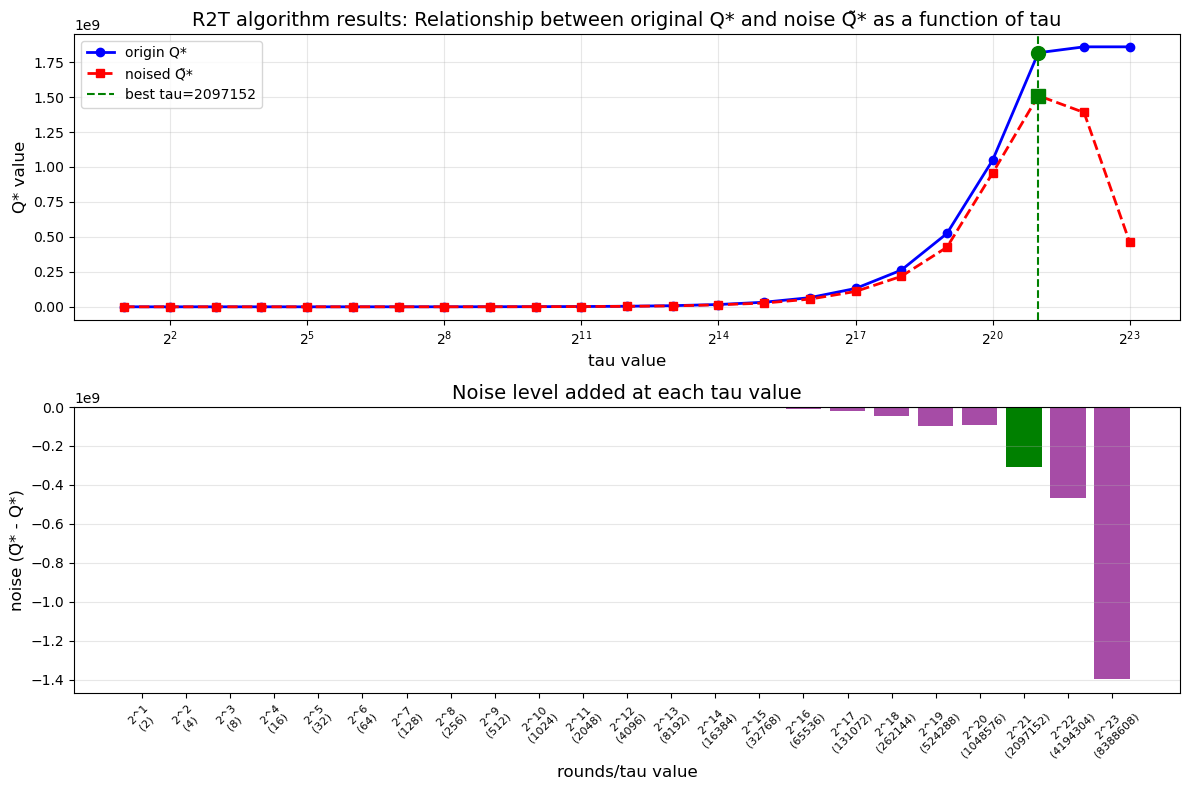

C:\Users\车睿佳\AppData\Local\Temp\ipykernel_7484\2768188198.py:68: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
C:\Users\车睿佳\AppData\Local\Temp\ipykernel_7484\2768188198.py:68: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from current font.
  plt.tight_layout()
C:\Users\车睿佳\AppData\Local\Temp\ipykernel_7484\2768188198.py:68: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from current font.
  plt.tight_layout()
C:\Users\车睿佳\AppData\Local\Temp\ipykernel_7484\2768188198.py:68: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
C:\Users\车睿佳\AppData\Local\Temp\ipykernel_7484\2768188198.py:68: UserWarning: Glyph 21051 (\N{CJK UNIFIED IDEOGRAPH-523B}) missing from current font.
  plt.tight_layout()
C:\Users\车睿佳\AppData\Local\Temp\ipykernel_7484\2768188198.py:68: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current f

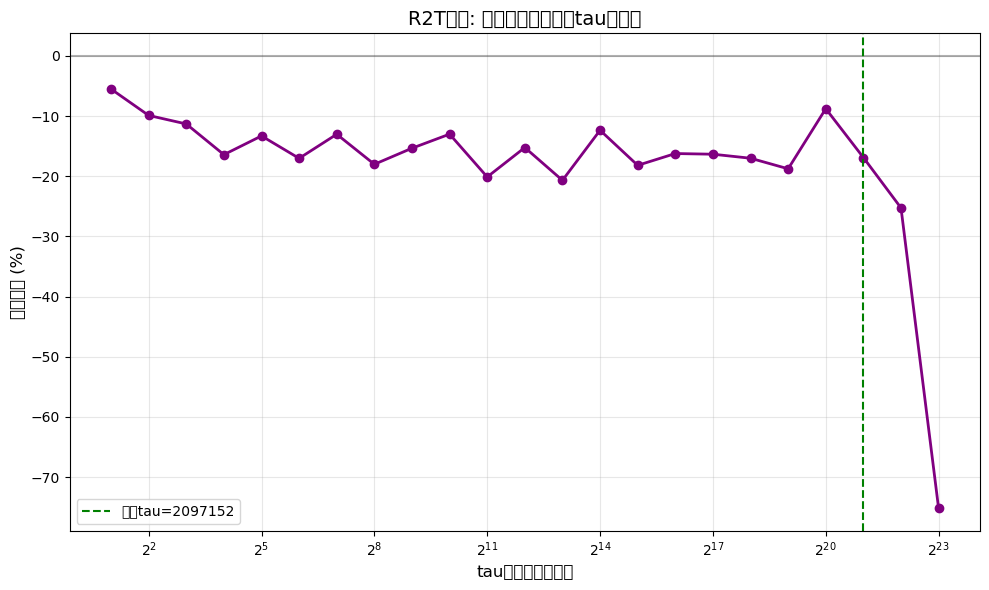

In [25]:
plot_r2t_results(tau_values, Q_values, Q_noisy_values, optimal_tau)